# How big are lgb trees? Any smaller than sk trees?
#   - [-] Figure out repr to evaluate model_size ~ (n_species, n_recs)
#       - Complication: in gbdt mode lgb trains n_classes * num_boost_round trees, which will complicate the comparison
#       - Instead, jump straight to rf mode to make the comparison (-> 20180706_lgb_rf.ipynb)

# lgb reference
#   - https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
#   - https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
#   - https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst
#   - https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
#   - https://sites.google.com/view/lauraepp/parameters

In [ ]:
from notebooks import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic


In [ ]:
# # Load a gbm run
# #   - [XXX Train instead of loading from disk, to avoid any stale pickling issues]
# model_dirs = [Path(d) for d in glob.glob(f'{artifact_dir}/20180705-033522-b6889a7/*')]
# searches = (
#     DF(
#         dict(search=joblib.load(d / 'estimator.pkl'))
#         for d in model_dirs
#     )
#     .assign(
#         skgbm=lambda df: df.search.map(lambda x: x.classifier_),
#         gbm=lambda df: df.skgbm.map(lambda x: x.booster_),
#     )
# )
# display(
#     searches,
# )
#
# # Pick a gbm to inspect
# search = searches.search[0]
# skgbm = search.classifier_

In [ ]:
# Generate data
random_state = np.random.RandomState(0)
n = 100
f = 10
X = random_state.rand(n, f)
classes = list(string.ascii_lowercase)
y = np_sample(classes, n=n, replace=True)
yi = lambda y: np.array([list(classes).index(_y) for _y in y])  # lgb api wants num labels, not str labels
(X_train, X_test, y_train, y_test) = sk.model_selection.train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
)
display(
    (X.shape, y.shape),
    y[:5],
    (X_train.shape, y_train.shape),
    (X_test.shape, y_test.shape),
)

((100, 10), (100,))

array(['b', 'e', 'j', 'q', 'v'], dtype='<U1')

((80, 10), (80,))

((20, 10), (20,))

In [ ]:
# Make lgb data
lgb_train = lgb.Dataset(X_train, yi(y_train), free_raw_data=False)
lgb_test = lgb.Dataset(X_test, yi(y_test), free_raw_data=False)

In [ ]:
lgb_train_kwargs = dict(
    # lgb.train args that feel like they belong in lgb_params instead

    num_boost_round=10,
    #   - Default: 100
    #   - "Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems"

    # early_stopping_rounds=None,
    #   - Default: None (disabled)
    #   - "Activates early stopping. The model will train until the validation score stops improving."
    #   - "Requires at least one validation data and one metric. If there's more than one, will check all of them except
    #     the training data."
    #   - "If early stopping occurs, the model will add ``best_iteration`` field"

    # learning_rates=None,
    #   - Default: None
    #   - Dynamic learning rate
    #   - learning_rates: list, callable or None, optional (default=None)
    #       List of learning rates for each boosting round or a customized function that calculates ``learning_rate``
    #       in terms of current number of round (e.g. yields learning rate decay).

)
lgb_params = dict(
    # https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst

    # Core Parameters
    objective='multiclass',
    #   - Must also set num_class
    boosting='gbdt',
    # num_iterations=100,
    #   - [Deprecated: moved to .train]
    learning_rate=.01,
    # num_leaves=31,
    # tree_learner='serial',
    #   - Single machine, multicore: 'serial' (default)
    #   - [ignore] Distributed training: 'feature' | 'data' | 'voting'
    #   - https://github.com/Microsoft/LightGBM/blob/master/docs/Parallel-Learning-Guide.rst
    # num_threads=0,
    # device_type='cpu',
    #   - 'cpu' (default) | 'gpu'
    #   - Would gpu need rebuild? https://github.com/Microsoft/LightGBM/blob/master/docs/Installation-Guide.rst#build-gpu-version
    #   - "Note: it is recommended to use the smaller max_bin (e.g. 63) to get the better speed up" (below)
    #   - "Note: for the faster speed, GPU uses 32-bit float point to sum up by default, so this may affect the
    #     accuracy for some tasks. You can set gpu_use_dp=true to enable 64-bit float point, but it will slow down
    #     the training"
    seed=0,
    #   - Generates all seeds (e.g. data_random_seed)

    # Learning Control Parameters
    # max_depth=-1,
    #   - -1 = no limit
    min_data_in_leaf=1,
    #   - 20 (default) is too big when data is small [https://github.com/Microsoft/LightGBM/issues/907]
    # bagging_fraction=1.0,
    #   - Sample data per tree (without replacement)
    #   - Requires bagging_freq > 0
    # bagging_freq=0,
    #   - Bag at every kth iteration (0 = disable)
    #   - Requires bagging_fraction < 1
    # feature_fraction=1.0,
    #   - Sample features per tree
    # early_stopping_round=0,
    #   - [Deprecated: moved to .train]
    # max_delta_step=0.0,
    #   - "used to limit the max output of tree leaves"
    #   - "<= 0 means no constraint"
    #   - "the final max output of leaves is learning_rate * max_delta_step"
    # lambda_l1=0.0,
    #   - L1 regularization
    # lambda_l2=0.0,
    #   - L2 regularization
    # min_gain_to_split=0.0,
    #   - "the minimal gain to perform split"

    # IO Parameters
    #   - TODO Grok more of these: https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst#io-parameters
    verbosity=1,
    max_bin=63,
    #   - Default: 255
    #   - "it is recommended to use the smaller max_bin (e.g. 63) to get the better speed up" (from cpu/gpu)
    #   - "max number of bins that feature values will be bucketed in"
    #   - "small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)"
    #   - "LightGBM will auto compress memory according to max_bin. For example, LightGBM will use uint8_t for
    #     feature value if max_bin=255"
    # min_data_in_bin=3,
    #   - "use this to avoid one-data-one-bin (potential over-fitting)"
    # bin_construct_sample_cnt=200000,
    #   - "number of data that sampled to construct histogram bins"
    #   - "setting this to larger value will give better training result, but will increase data loading time"
    #   - "set this to larger value if data is very sparse"
    #   - TODO Tune with len(X)
    # two_round=False,
    #   - "set this to true if data file is too big to fit in memory"
    # save_binary=False,
    #   - "save the dataset (including validation data) to a binary file. This speed ups the data loading for the next time"
    # enable_load_from_binary_file=True,
    #   - "set this to true to enable autoloading from previous saved binary datasets"

    # Objective Parameters
    num_class=len(classes),
    #   - Default: 1
    #   - Required for objective='multiclass'

    # Metric Parameters
    #   - [ignore]

    # Network Parameters
    #   - [ignore]

    # GPU Parameters
    #   - [ignore]

)

In [ ]:
evals_result = {}
gbm = lgb.train(
    **lgb_train_kwargs,
    params=lgb_params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'test'],
    evals_result=evals_result,
    verbose_eval=1,
    #   - Print every n rounds
    keep_training_booster=True,
    #   - Default: False
    #   - Whether to retain memory for further training [https://github.com/Microsoft/LightGBM/issues/668]
    #   - FIXME .save_model only includes params if keep_training_booster=True
    #       - Seems like it was intended to include params in both cases? [https://github.com/Microsoft/LightGBM/issues/1364]
)
display(
    # evals_result,  # evals_result['test']['multi_logloss']: np.ndarray, same as the verbose output
)

[1]	train's multi_logloss: 3.08945	test's multi_logloss: 6.34928
[2]	train's multi_logloss: 2.97995	test's multi_logloss: 6.34845
[3]	train's multi_logloss: 2.88184	test's multi_logloss: 6.35277
[4]	train's multi_logloss: 2.79294	test's multi_logloss: 6.35705
[5]	train's multi_logloss: 2.71163	test's multi_logloss: 6.36131
[6]	train's multi_logloss: 2.63671	test's multi_logloss: 6.36526
[7]	train's multi_logloss: 2.56724	test's multi_logloss: 6.3692


[8]	train's multi_logloss: 2.50247	test's multi_logloss: 6.37355
[9]	train's multi_logloss: 2.4418	test's multi_logloss: 6.37788
[10]	train's multi_logloss: 2.38474	test's multi_logloss: 6.38205


In [ ]:
# dir(gbm)

In [ ]:
x = gbm.dump_model()
x.keys()
toolz.keyfilter(lambda k: k not in ['tree_info'], x)

dict_keys(['name', 'version', 'num_class', 'num_tree_per_iteration', 'label_index', 'max_feature_idx', 'feature_names', 'tree_info'])

{
  'name': 'tree',
  'version': 'v2',
  'num_class': 26,
  'num_tree_per_iteration': 26,
  'label_index': 0,
  'max_feature_idx': 9,
  'feature_names': [
    'Column_0',
    'Column_1',
    'Column_2',
    'Column_3',
    'Column_4',
    'Column_5',
    'Column_6',
    'Column_7',
    'Column_8',
    'Column_9'
  ]
}

In [ ]:
# FIXME num_iteration=-1 means "best model", but should mean "all models" [https://github.com/Microsoft/LightGBM/issues/1494]
# gbm.save_model('/tmp/boosted.txt')  # Same as _save_model_to_string
print('\n'.join(
    gbm._save_model_to_string(num_iteration=-1)
.split('\n')[-10:]).rstrip())

[num_machines: 1]
[local_listen_port: 12400]
[time_out: 120]
[machine_list_filename: ]
[machines: ]
[gpu_platform_id: -1]
[gpu_device_id: -1]
[gpu_use_dp: 0]


In [ ]:
# FIXME num_iteration=-1 means "best model", but should mean "all models" [https://github.com/Microsoft/LightGBM/issues/1494]
# FIXME 'parameters' in _save_model_to_string don't survive a pickle roundtrip
#   - Looks like because they're ignored by LoadModelFromString
#   - https://github.com/Microsoft/LightGBM/blob/v2.1.2/src/boosting/gbdt_model_text.cpp#L304 -> search "parameters", "config_"
_gbm = pickle.loads(pickle.dumps(gbm))
print('\n'.join(
    _gbm._save_model_to_string(num_iteration=-1)
.split('\n')[-10:]).rstrip())

Column_1=429
Column_2=229
Column_4=128
Column_3=124
Column_8=107
Column_7=84
Column_5=79
Column_6=45
Column_9=42


In [ ]:
# Compact plaintext repr
#   - FIXME num_iteration=-1 means "best model", but should mean "all models" [https://github.com/Microsoft/LightGBM/issues/1494]
def gbm_to_txt(gbm, num_iteration=-1):
    tmp_path = tempfile.mktemp()
    gbm.save_model(tmp_path, num_iteration=num_iteration)
    with open(tmp_path) as f:
        return f.read()

In [ ]:
# FIXME num_iteration=-1 means "best model", but should mean "all models" [https://github.com/Microsoft/LightGBM/issues/1494]
# TODO Why >>10 trees?
#   - Each iteration accumulates more trees than the last
#   - Each round trains 26 trees (26 = num_classes)
#   - -1 means "best iteration", which will have some intermediate number of trees
gbm_txt = gbm_to_txt(gbm, num_iteration=-1)
print(gbm_txt[:1000] + '\n\n...\n\n' + gbm_txt[-2000:])

tree
version=v2
num_class=26
num_tree_per_iteration=26
label_index=0
max_feature_idx=9
objective=multiclass num_class:26
feature_names=Column_0 Column_1 Column_2 Column_3 Column_4 Column_5 Column_6 Column_7 Column_8 Column_9
feature_infos=[0.012171156943258765:0.99033894739670436] [0.00054596489699565431:0.99201124341447411] [0.0038603515102610952:0.98837383805922618] [0.01323685775889949:0.96218854511743823] [0.0078841035084403766:0.99980857811696533] [0.058534922235558784:0.99796225132867344] [0.019193198309333526:0.99189032915462938] [0.01203622289765427:0.98734875707396819] [0.016328502683707891:0.99440078964767942] [0.0046954761925470656:0.99927799392217109]
tree_sizes=908 1188 826 462 617 1266 823 754 1495 985 542 672 754 904 399 1117 832 684 1107 608 549 471 898 1055 330 613 947 860 545 1574 474 853 929 695 1148 870 788 553 861 623 489 840 782 699 1784 849 484 718 842 1345 722 780 943 690 626 860 866 774 697 702 924 1112 865 1254 623 1024 332 1004 620 928 1377 543 333 867 766 63

In [ ]:
# .best_iteration is nonzero only if early_stopping is enabled and happens
gbm.best_iteration

0

-1


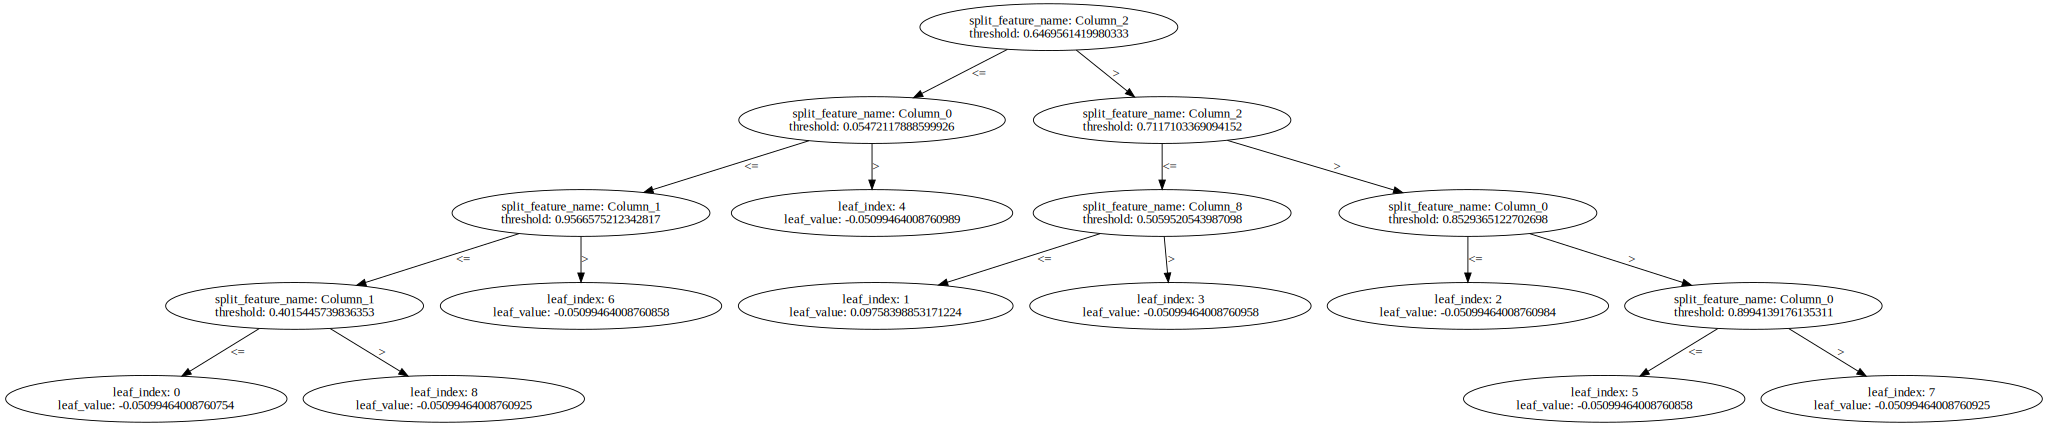

0


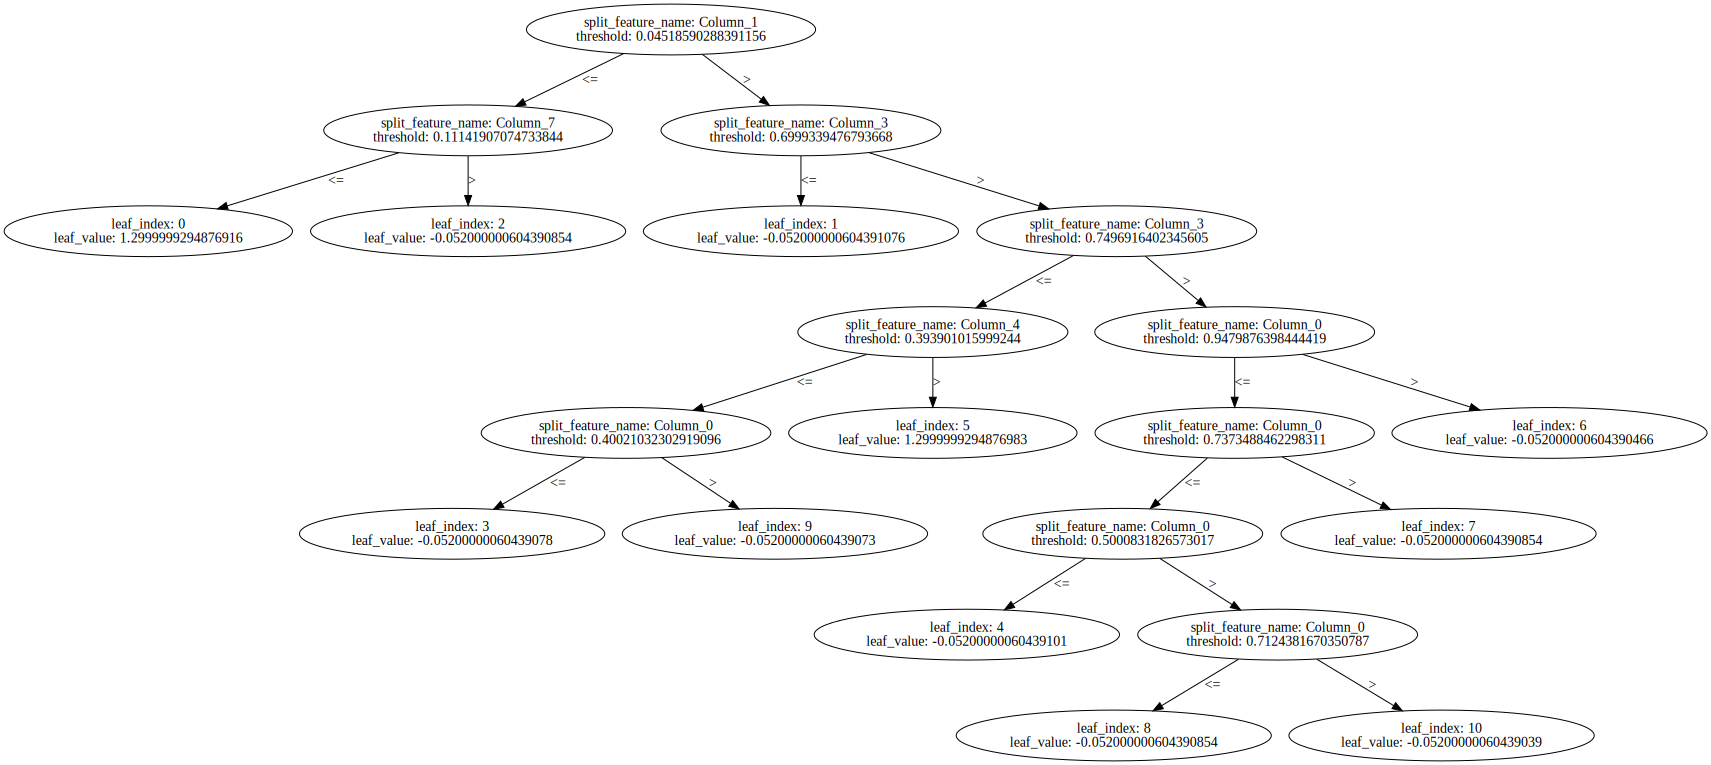

1


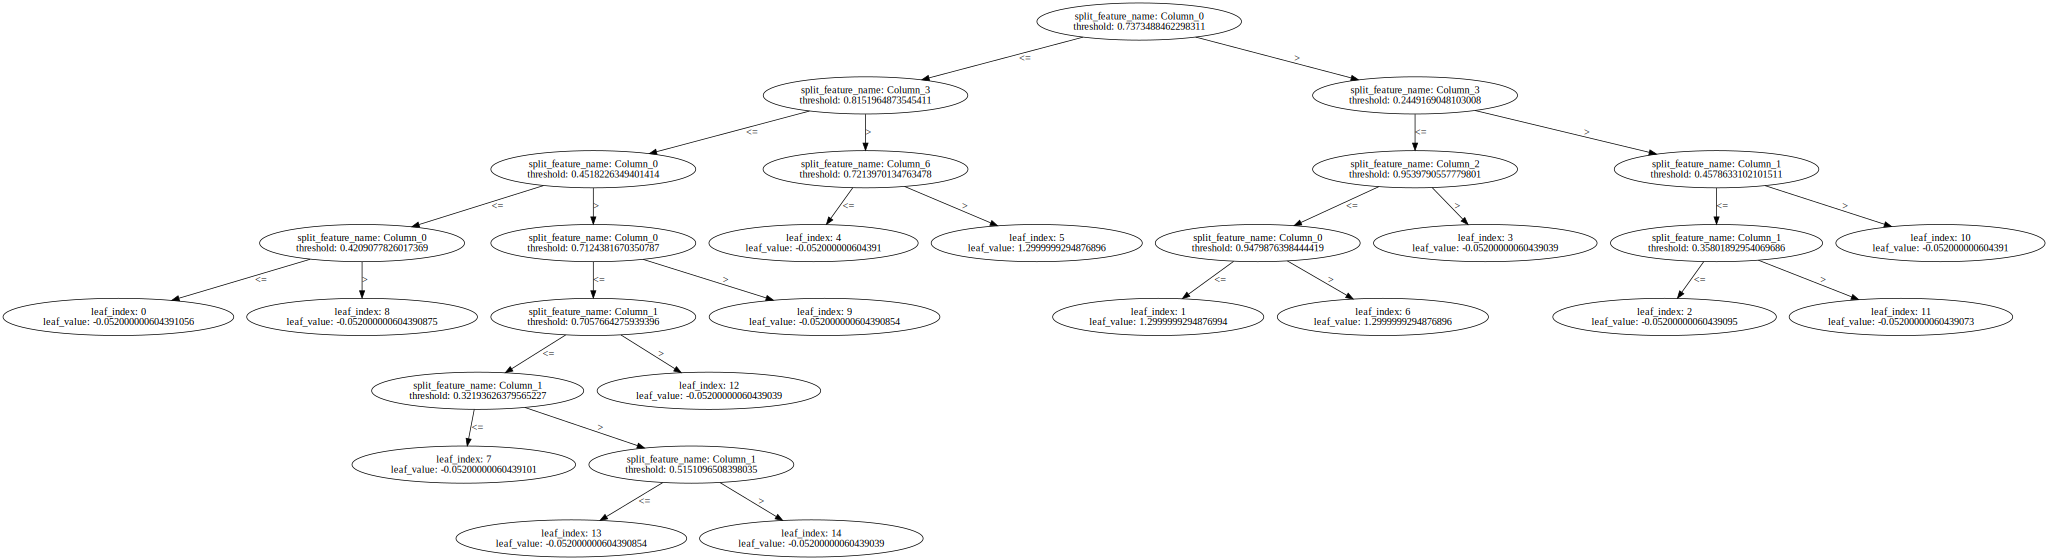

2


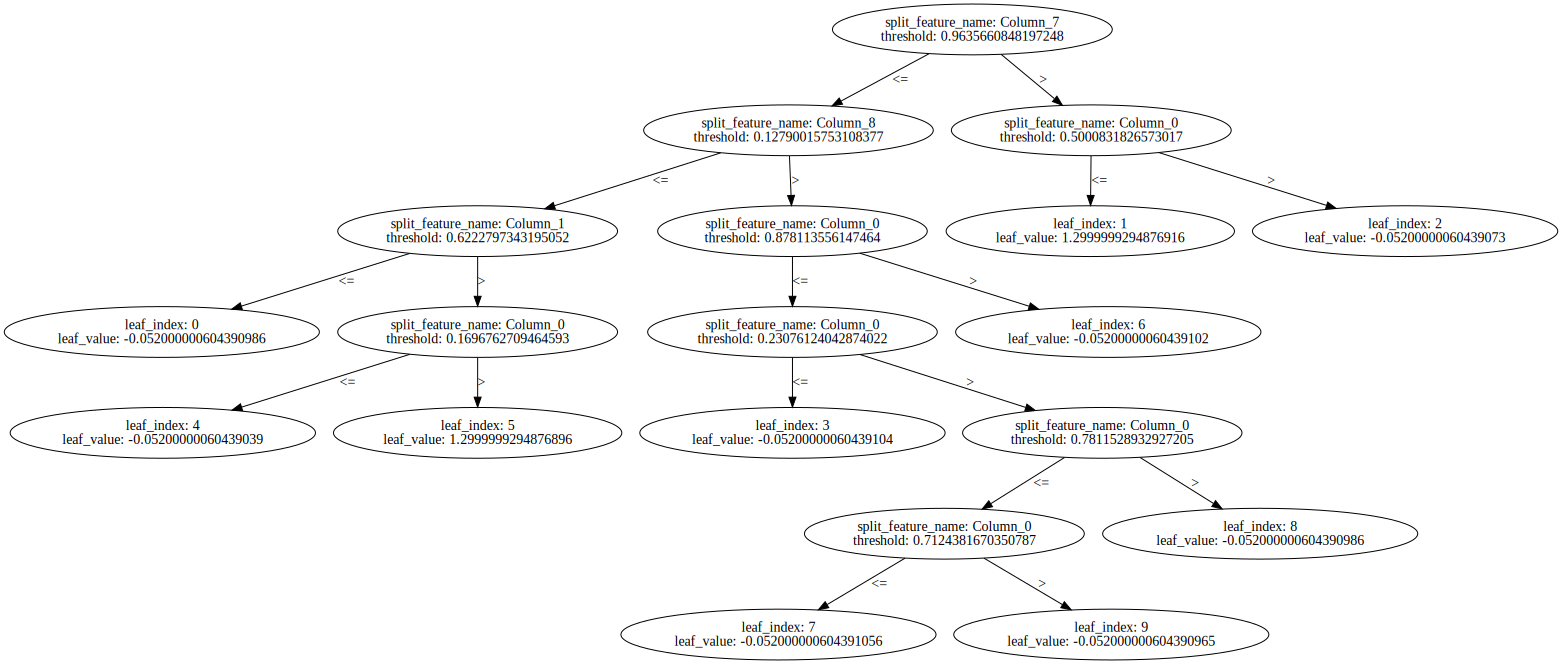

3


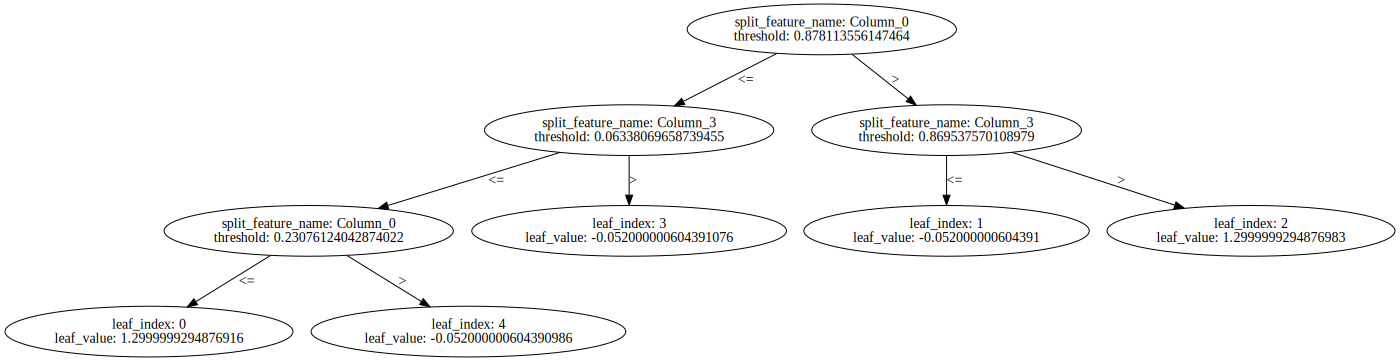

4


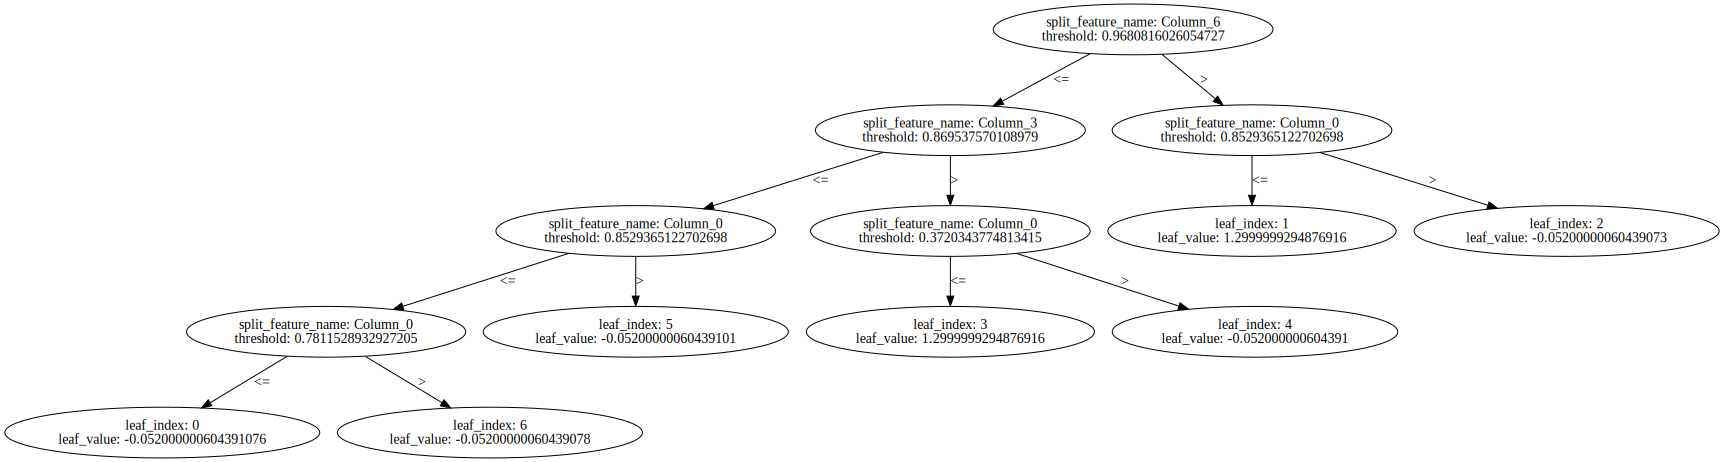

5


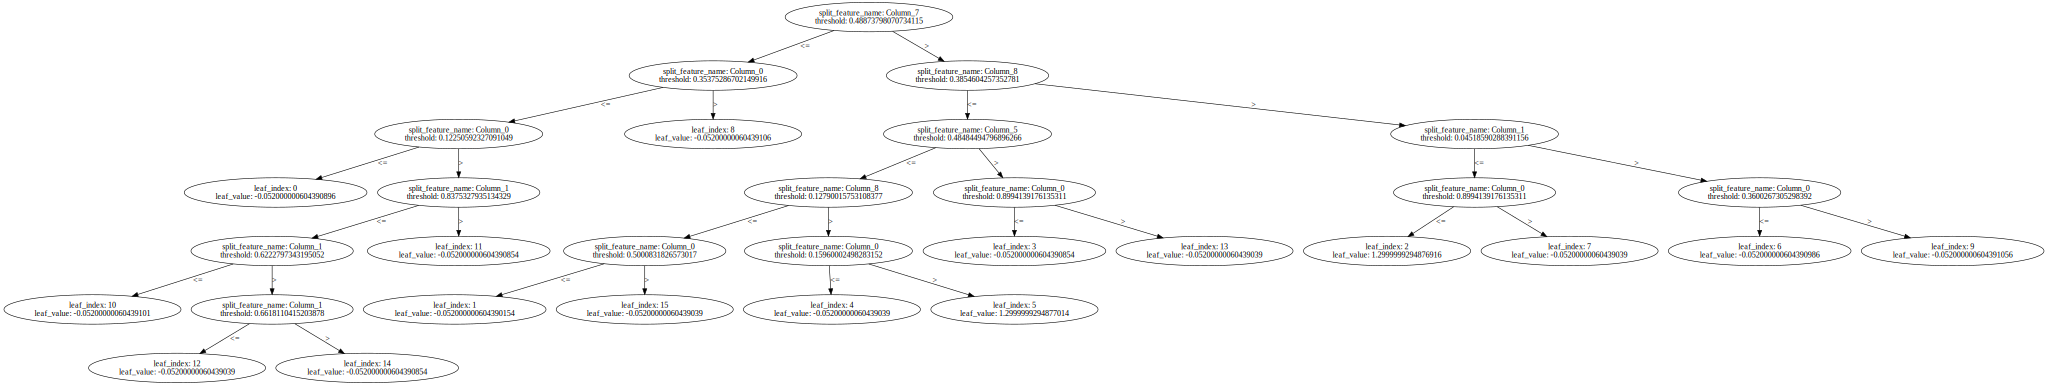

6


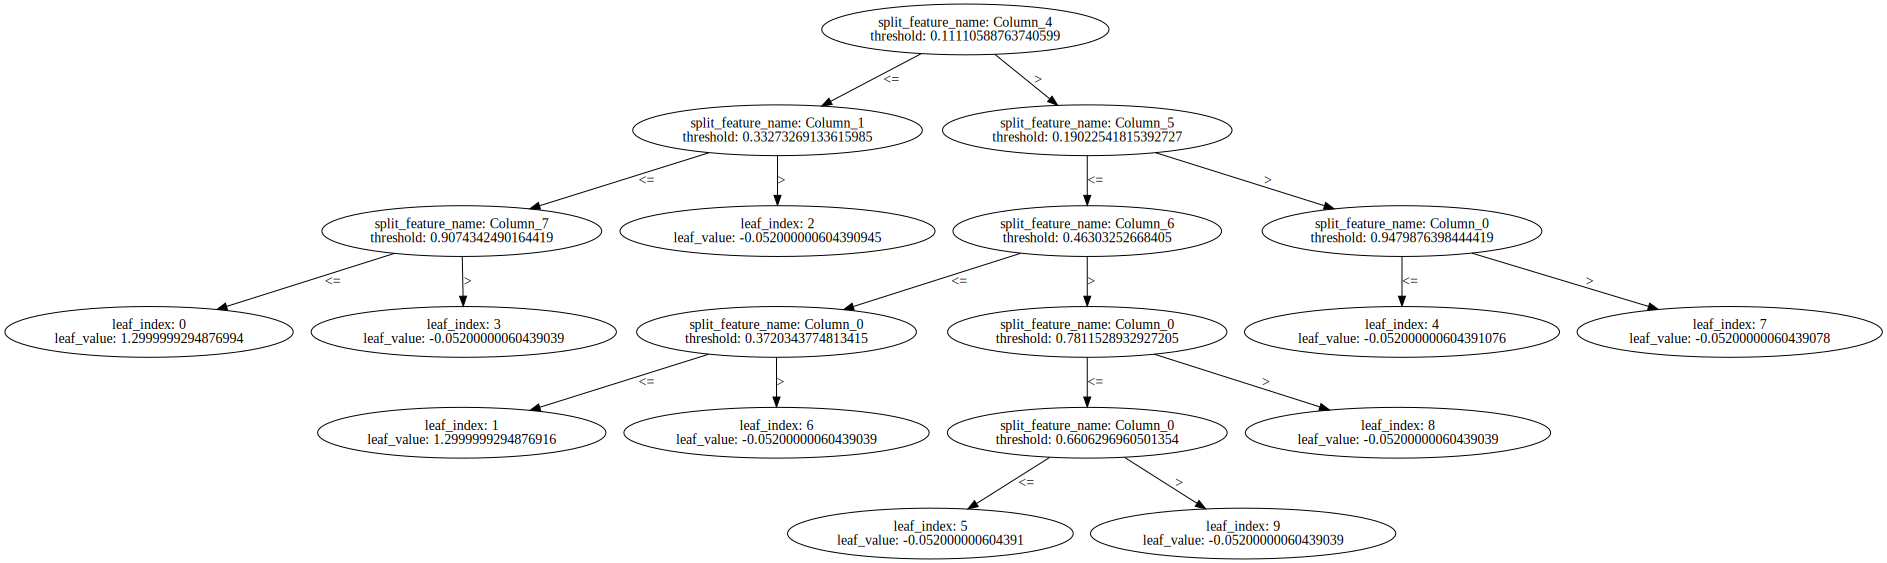

7


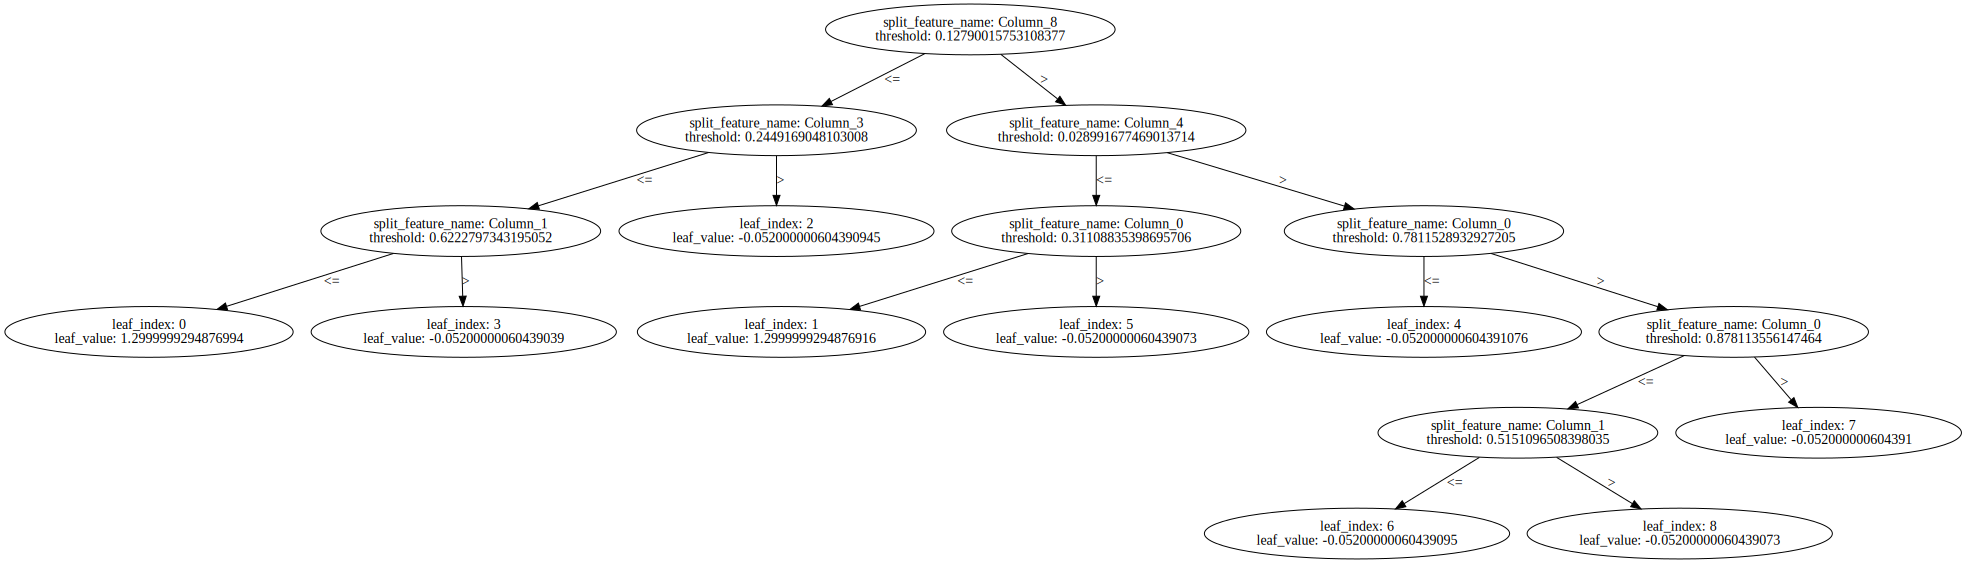

8


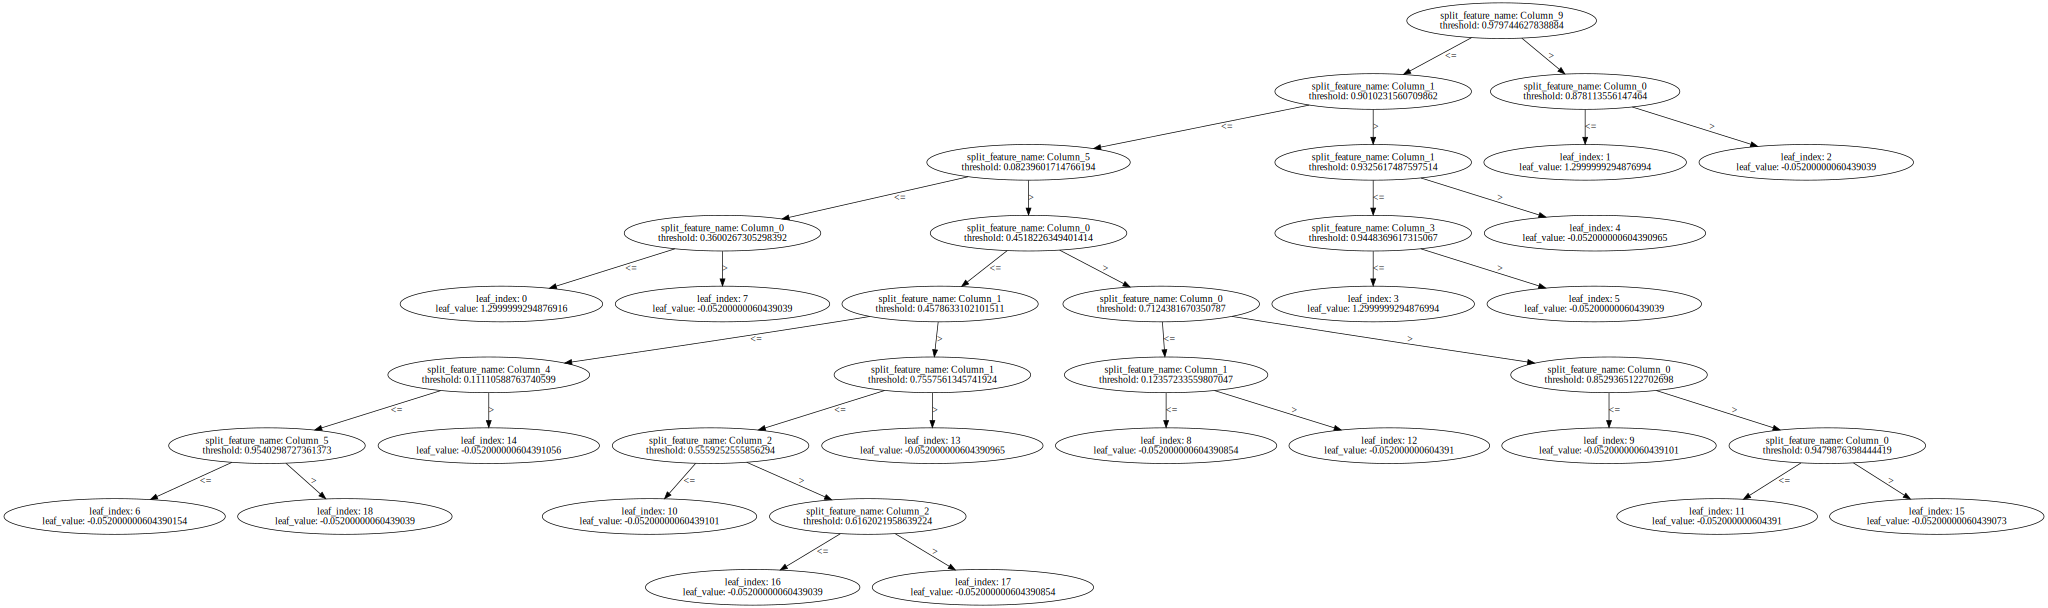

9


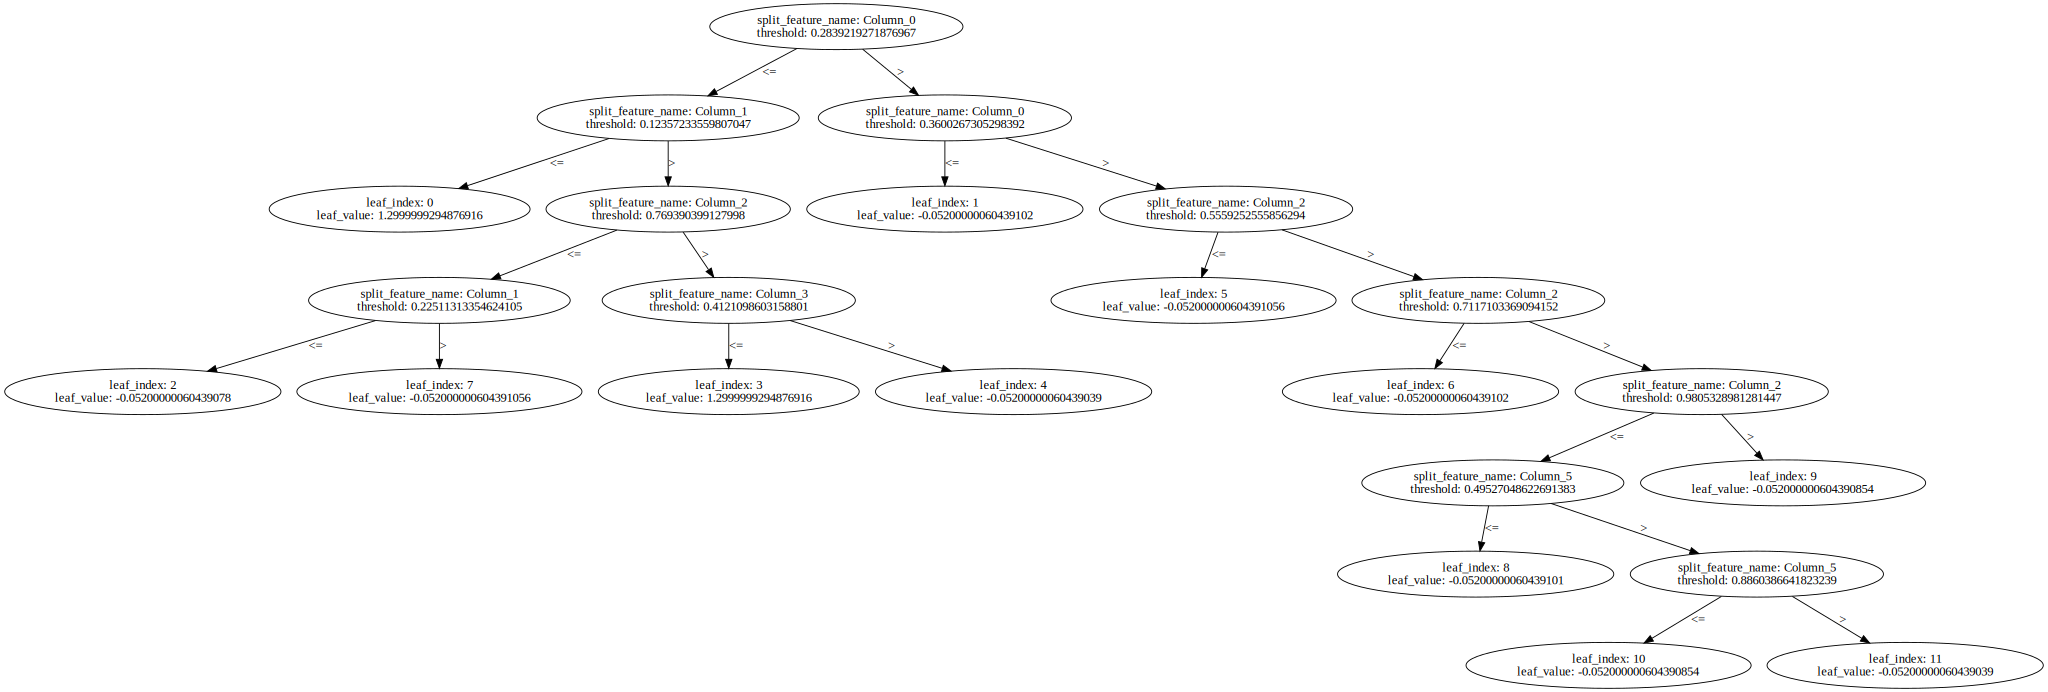

10


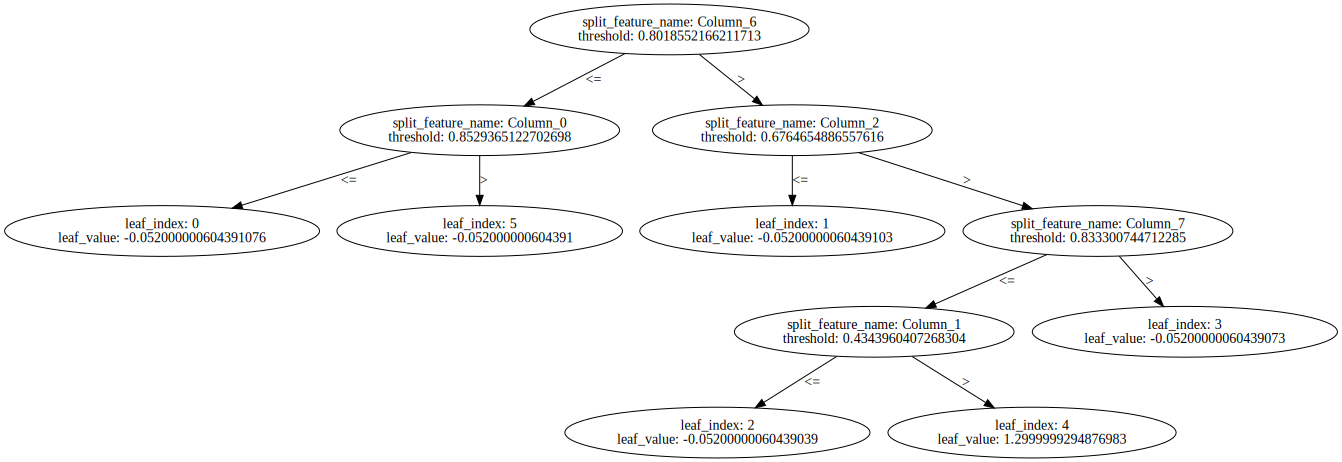

In [ ]:
# Viz tree
for tree_index in [-1, 0] + list(1 + np.arange(0, gbm.current_iteration())):
    print(tree_index)
    display(lgb.create_tree_digraph(
        gbm,
        tree_index=tree_index,
        # show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
        # precision=3,
    ))

In [ ]:
STOP

In [ ]:
# Train an skgbm (sk api)
#   - XXX Can't specify all lgb params here... -- TODO Maybe if we override get_params it will just work..?
#   - Alternatively, autogen sk __init__ args like Parameters.rst (and send a PR):
#       - https://github.com/Microsoft/LightGBM/blob/master/helper/parameter_generator.py#L106
skgbm = lgb.LGBMClassifier(

    # boosting_type="gbdt",
    # num_leaves=31,
    # max_depth=-1,
    # learning_rate=0.1,  # Default: 0.1
    n_estimators=20,  # Default: 100
    # subsample_for_bin=200000,
    # objective=None,  # Automatically set by LGBMModel subclass
    # class_weight=None,
    # min_split_gain=0.,
    # min_child_weight=1e-3,
    # min_child_samples=20,
    # subsample=1.,
    # subsample_freq=1,
    # colsample_bytree=1.,
    # reg_alpha=0.,
    # reg_lambda=0.,

    random_state=0,
    # n_jobs=-1,
    silent=False,  # XXX Has no effect [looks like it should work, from the code...]
    # **kwargs,  # WARNING Avoid: might interact badly with sklearn .get_params()

)
skgbm.fit(X, y)
display(
    skgbm,
    # skgbm._evals_result,  # XXX Nothing [looks like it should work, from the code...]
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=20,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [ ]:
# Inspect skgbm
display(
    # dir(skgbm),
    # [k for k in dir(skgbm) if k.endswith('_') and not k.endswith('__')],
    {k: getattr(skgbm, k) for k in dir(skgbm) if k.endswith('_') and not k.endswith('__')},
    # dirs(skgbm),
)

In [ ]:
# .booster_ is the lgb model inside the sk model
display(
    dir(skgbm.booster_),
)

In [ ]:
# Plot training metrics
#   - e.g. https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/plot_example.py
#   - TODO Maybe have to lgb.train instead of sk .fit to get .evals_result_?
# lgb.plot_metric(skgbm.booster_.evals_result_)
# lgb.plot_metric?

In [ ]:
# Viz tree
for tree_index in range(1):
    display(lgb.create_tree_digraph(
        skgbm.booster_,
        tree_index=tree_index,
        show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
    ))

In [ ]:
# Pickling
#   - e.g. https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
#   - TODO Measure size of these ~ (n_species, n_recs)
#   - TODO Verify that this dumps all iterations, unlike save_model/dump_model
display(
    # len(joblib_dumps(search)),
    len(joblib_dumps(skgbm)),
    len(joblib_dumps(skgbm.booster_)),
    skgbm.predict_proba(np.random.RandomState(0).rand(1, f)),
    joblib_loads(joblib_dumps(skgbm)).predict_proba(np.random.RandomState(0).rand(1, f)),
    # search.classifier_.predict_proba(np.random.RandomState(0).rand(1, f)),
    # joblib_loads(joblib_dumps(search)).classifier_.predict_proba(np.random.RandomState(0).rand(1, f)),
)

In [ ]:
# Compact plaintext repr
#   - FIXME num_iteration=-1 means "best model", but should mean "all models" [https://github.com/Microsoft/LightGBM/issues/1494]
def gbm_to_txt(gbm, num_iteration=-1):
    tmp_path = tempfile.mktemp()
    gbm.save_model(tmp_path, num_iteration=num_iteration)
    with open(tmp_path) as f:
        return f.read()
gbm_txt = gbm_to_txt(skgbm.gbm_)
print(gbm_txt[:250] + ' ...\n...')
display(
    len(gbm_txt),
)

In [ ]:
# Python dict repr
#   - FIXME num_iteration=-1 means "best model", but should mean "all models" [https://github.com/Microsoft/LightGBM/issues/1494]
gbm_dump = skgbm.booster_.dump_model(num_iteration=-1)
display(
    {k: v for k, v in gbm_dump.items() if k in [
        'name', 'version', 'num_class', 'num_tree_per_iteration', 'label_index', 'max_feature_idx',
        # 'feature_names',
        # 'tree_info',
    ]},
    gbm_dump['tree_info'][0],
)